# Example: Bayesian Inference for a Simple pyhf Model

In [3]:
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
import pytensor 

import pymc as pm
import arviz as az
import pyhf
import numpy as np
import matplotlib.pyplot as plt

### Defining the pyhf model

In [15]:
### Signal, background and observation
sig = [5.0, 4.0]
bkg = [40.0, 45.0]
db = [0.1, 0.1]

### Setting up the pyhf model
model = pyhf.simplemodels.uncorrelated_background(sig, bkg, db)

### Observations    
    ## Corresponding to an actual signal strength of 2
dummyPars = [2.0, 1.0, 1.0]
obs = model.expected_actualdata(dummyPars)

### Class definition

In [5]:
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, func, name):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

### Inference

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigStr]
>Slice: [gamma_1]
>Slice: [gamma_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<AxesSubplot: title={'center': 'sigStr'}>,
        <AxesSubplot: title={'center': 'sigStr'}>]], dtype=object)

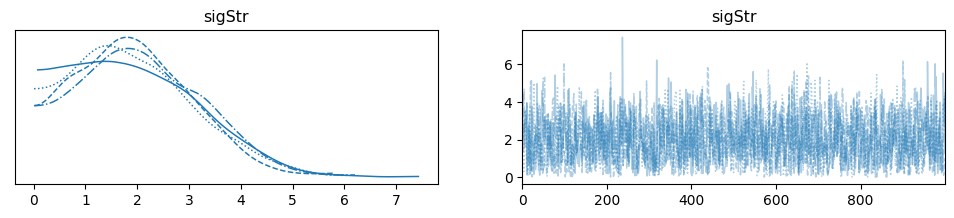

In [18]:
mainOp = Op(model.expected_actualdata, "mainOp")

### Opening the pyMC model space
with pm.Model() as basic_model:
    ## TensorVar input parameters [sigStr, gamma_i, ... ,gamma_nBins]
    pars = [pm.HalfNormal("sigStr", sigma=2.5), pm.Gamma("gamma_1", alpha=20, beta=20), pm.Gamma("gamma_2", alpha=20, beta=20)]
    pars = pt.as_tensor_variable(pars)

    main = pm.Deterministic("mainDet", mainOp(pars)) 

    pm.Poisson("main", mu=main, observed=obs)

    ## Sampling ...
    post_data = pm.sample()

### Trace for the signal strength
az.plot_trace(post_data, var_names=["sigStr"])